In [1]:
import os
import time
import random
import numpy as np

import torch
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm, LeakyReLU, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_scatter import scatter

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import json
import networkx as nx
import copy

In [2]:
def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    """
    Internal helper to parse graphs from node-link JSON format.
    """
    result_dict = {}
    for key in string_dict:
        data = copy.deepcopy(string_dict[key])
        if 'edges' in data:
            data["links"] = data.pop("edges")
        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
        file_handle.write(json_string)

In [3]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        # SK - note how the dimensions of h_i and h_j were recast compared to forward()
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)

    def aggregate(self, inputs, index, ptr=None, dim_size=None):

        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        aggr_out = scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce=self.aggr)

        return aggr_out

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """

        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [4]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=49, edge_dim=1, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - a single PyG graph

        Returns:
            out: (1,) - prediction for the single graph
        """
        h = self.lin_in(data.x)  # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr)  # (n, d) -> (n, d)
            # Residual connection after each MPNN layer

        # If working with a single graph, we don't need batch handling
        h_graph = h.mean(dim=0, keepdim=True)  # (n, d) -> (1, d), mean pooling over nodes

        out = self.lin_pred(h_graph)  # (1, d) -> (1, 1)

        return out.view(-1)  # (1,) - Flatten to return a single scalar

In [5]:
# Load embeddings
embedding_df = pd.read_csv("embeddings.csv")
embedded_atoms = list(embedding_df['Atoms'])
embed_dict = {}
for i in range(len(embedding_df)):
    vec = np.fromstring(embedding_df.loc[i,'Embeddings'].replace('\n','').strip('[]'), sep=' ')
    embed_dict[embedded_atoms[i]] = vec        
embed_dict['H'] = np.zeros(30)

# Load lookup table
lookup_df = pd.read_csv("lookup.csv")
atom_dict = {row['Element']: row['Z'] for _, row in lookup_df.iterrows()}

# Load graph data (duplicates)
graph_data = load_data_from_file("graph_data_duplicates.json")

# Load the model, hard coded layer and embedding dimension with best parameters from hyperparameter tuning
model = MPNNModel(num_layers=6, emb_dim=94, in_dim=49, edge_dim=4, out_dim=1)
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))
model.eval()  # Make sure the model is in evaluation mode

MPNNModel(
  (lin_in): Linear(in_features=49, out_features=94, bias=True)
  (convs): ModuleList(
    (0-5): 6 x MPNNLayer(emb_dim=94, aggr=add)
  )
  (lin_pred): Linear(in_features=94, out_features=1, bias=True)
)

In [6]:
orb_list = ['1s',
         '2s',
         '2p',
         '2p3/2',
         '3s',
         '3p',
         '3p3/2',
         '3d',
         '3d5/2',
         '4s',
         '4p3/2',
         '4d',
         '4d5/2',
         '4f7/2',
         '5s',
         '5p3/2',
         '5d5/2']

bond_dict = {'SINGLE':1, 'DOUBLE':2, 'TRIPLE':3, 'NONE':0}

In [7]:
# Prepare a list for results
results = []

# Iterate through each graph in the dataset
for mol_name, graph in graph_data.items():
    
    # Get node attributes
    targets = list(nx.get_node_attributes(graph, "target").values())
    atom_idx = targets.index(True)
    atoms = list(nx.get_node_attributes(graph, "atom_type").values())
    orbitals = list(nx.get_node_attributes(graph, "orbitals").values())
    
    # Extract the target atom and orbital
    target_atom_idx = int(mol_name.split('_')[1])  # Get atom index from molecule name
    target_orbital = orbitals[target_atom_idx][0]  # Get the first orbital of the target atom
    
    if target_orbital == -1:
        # If orbital type is -1, prepend a predicted binding energy of -1
        results.append([mol_name.split('_')[0], atoms[target_atom_idx], target_orbital, -1])
        continue
    
    # Construct PyG graph
    x = np.zeros((len(targets), 49))
    
    # Set target atom
    x[target_atom_idx, 0] = 1  # target atom
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    x[:, 1] = charge
    
    atom_embeds = np.array([embed_dict[a] for a in atoms])
    x[:, 2:32] = atom_embeds
    x[target_atom_idx, 32 + orb_list.index(target_orbital)] = 1  # orbital one-hot encoding for target
    
    x = torch.tensor(x, dtype=torch.float)
    
    # Index is Z-1 for lookup table
    energy = float(lookup_df.loc[atom_dict[atoms[target_atom_idx]]-1, target_orbital])
    
    edges = list(graph.edges)

    if len(edges) == 0:  # If there are no edges, add self-loops
        edge_index = torch.arange(len(targets), dtype=torch.long).view(1, -1).repeat(2, 1)
        edge_attr = torch.zeros(1, 4)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        bond_types = list(nx.get_edge_attributes(graph, "bond_type").values())
        edge_attr = np.zeros((4, len(bond_types)))
        for j, b in enumerate(bond_types):
            edge_attr[bond_dict[b], j] = 1
        edge_attr = torch.tensor(edge_attr, dtype=torch.long).t().contiguous()
    
    # PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=energy)
    
    # Model prediction
    with torch.no_grad():
        y_pred = model(data)
    
    # Prepend the predicted binding energy
    results.append([mol_name.split('_')[0], atoms[target_atom_idx], target_orbital, (y_pred.item() + data.y)])

In [8]:
results_df = pd.DataFrame(results, columns=['Molecule', 'Atom', 'Orbital', 'Binding Energy'])

In [9]:
results_df

,Molecule,Atom,Orbital,Binding Energy
0,[Ag],Ag,3d5/2,378.965583
1,C/C(=C\C(=O)C(F)(F)F)/O[Al](O/C(=C\C(=O)C(F)(F...,C,1s,293.233103
2,C/C(=C\C(=O)C(F)(F)F)/O[Al](O/C(=C\C(=O)C(F)(F...,C,1s,293.173124
3,C/C(=C\C(=O)C(F)(F)F)/O[Al](O/C(=C\C(=O)C(F)(F...,C,1s,292.566679
4,C/C(=C\C(=O)C(F)(F)F)/O[Al](O/C(=C\C(=O)C(F)(F...,C,1s,292.818245
...,...,...,...,...
129,CC(/C(=C/C(=O)C(C)(C)C)/O[Al](O/C(=C\C(=O)C(C)...,C,1s,289.119014
130,CC(/C(=C/C(=O)C(C)(C)C)/O[Al](O/C(=C\C(=O)C(C)...,C,1s,288.475682
131,CC(/C(=C/C(=O)C(C)(C)C)/O[Al](O/C(=C\C(=O)C(C)...,C,1s,287.937591
132,CC(/C(=C/C(=O)C(C)(C)C)/O[Al](O/C(=C\C(=O)C(C)...,C,1s,287.482183


(array([ 9.,  4.,  0.,  0., 78.,  1.,  0., 24.,  0., 18.]),
 array([ -1.        ,  68.6208052 , 138.2416104 , 207.8624156 ,
        277.4832208 , 347.104026  , 416.72483119, 486.34563639,
        555.96644159, 625.58724679, 695.20805199]),
 <BarContainer object of 10 artists>)

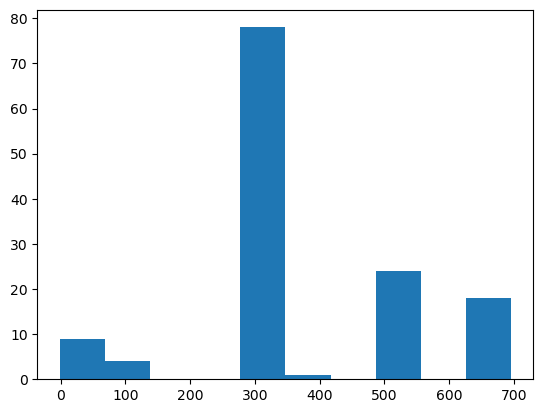

In [10]:
plt.hist(results_df['Binding Energy'])

In [13]:
results_df.to_csv('results.csv', index=False)